In [101]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [100]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [102]:
mnist.data.shape

(70000, 784)

In [105]:
X, y = mnist["data"], mnist["target"]

In [106]:
print(X.shape, y.shape)

(70000, 784) (70000,)


In [17]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [19]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [107]:
import matplotlib
import matplotlib.pyplot as plt

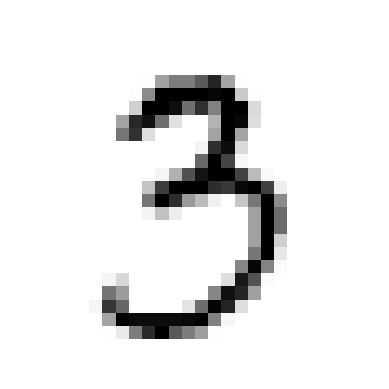

In [114]:
some_digit = X[20000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show()

In [115]:
y[20000]

3

In [116]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

Shuffling the Training Dataset that will guarantee that all cross-validation folds with be similiar

In [117]:
import numpy as np

In [118]:
shuffle_index = np.random.permutation(60000)
shuffle_index

array([25251, 22108, 55277, ..., 31289,  5123, 43463])

In [120]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [121]:
len(X_train)

60000

In [138]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Training a binary classification. Trying to find out one digit at a time, let's take number 4

y_test_5 = (y_test == 5)
y_test_5

y_train_5 = (y_train == 5)
y_train_5

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

X_train.head()

unique_classes = np.unique(y_train_5)
len(unique_classes)

y_train_5_v = y_train_5.values.reshape(-1, 1)
y_train_5_v

Using a SDGCClassifier. 

In [139]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [140]:
sgd_clf.predict([some_digit])

array([False])

In [141]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [143]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96535
0.9642
0.96755


In [145]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.83205, 0.86695, 0.85585])

In [146]:
from sklearn.base import BaseEstimator

class _5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [148]:
_5_clf = _5Classifier()
cross_val_score(_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9094 , 0.91085, 0.9087 ])

This shows 905 accuracy, but is it true. No because we are just finding out that only 10% of the images are 5s , and guessing an image is not 5 you'd be 90% right

Working on the Confusion Matrix, TP, FP, TN, FN

In [149]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict performs K-fold cross-validation, but returns predictions made on each test fold
Getting a clean prediction made by the model

In [151]:
y_train_pred

array([False, False, False, ..., False, False, False])

In [158]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[52681,  1898],
       [ 1464,  3957]])

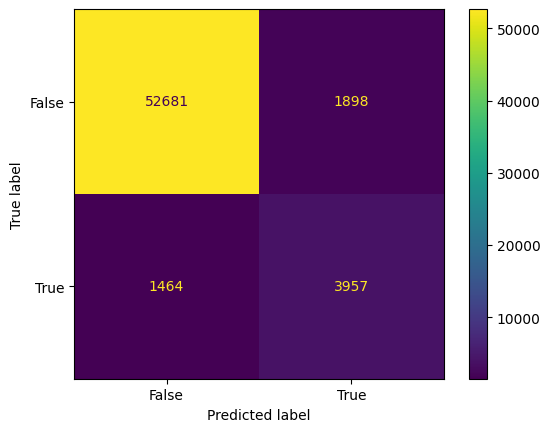

In [157]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=sgd_clf.classes_)
disp.plot()

Printed Confusion Matrix. With this we can find out precision and recall

In [163]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)

0.6758326216908626

In [164]:
recall_score(y_train_5, y_train_pred)

0.7299391256225789

Precision is 0.67 and Recall is 0.72

f1 score is

In [166]:
f1_score(y_train_5, y_train_pred)

0.7018446257538135

In [167]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-3407.67610696])

In [171]:
y_some_digit_pred = (y_scores > 0)
y_some_digit_pred

array([False])

Increasing the threshold decreses the recall. To decide the threshold, need to predict the scores of instances in the training set using cross_val_predict() function, changing the method to "Decision Function"

In [172]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [173]:
y_scores

array([-17132.06974508, -14049.35061019, -29561.51235084, ...,
        -4579.04026266, -20751.90852735, -12280.06391739])

In [174]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)

In [175]:
print(precision, recall, threshold)

[0.09035    0.09035151 0.09035301 ... 1.         1.         1.        ] [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00] [-105450.83984569 -104378.6692944  -103639.76044627 ...   28399.84009743
   28613.27580387   31189.96201435]


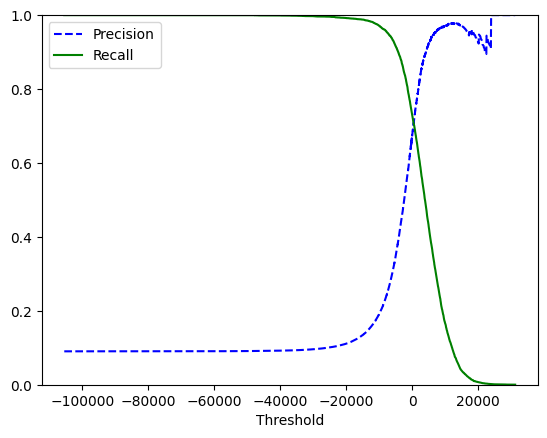

In [176]:
plt.plot(threshold, precision[:-1], "b--", label="Precision")
plt.plot(threshold, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

In [178]:
y_train_pred_90 = (y_scores > 70000)
y_train_pred_90

array([False, False, False, ..., False, False, False])

Plotting the ROC Curve

In [181]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

In [194]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'g--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

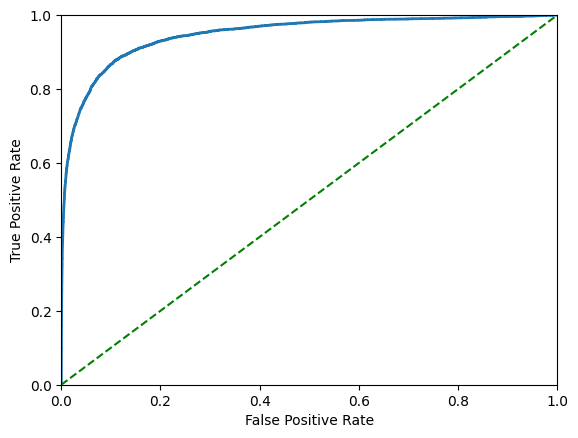

In [195]:
plot_roc_curve(fpr, tpr)

The ROC Curve

In [188]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9479849748519769

Training Random Forest Classifier with the ROC and F1 score

In [189]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [190]:
y_probas_forest

array([[0.99, 0.01],
       [0.97, 0.03],
       [1.  , 0.  ],
       ...,
       [0.59, 0.41],
       [0.98, 0.02],
       [1.  , 0.  ]])

In [191]:
y_scores_forest = y_probas_forest[:,1] #Probability of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

Comparison ROC Curve

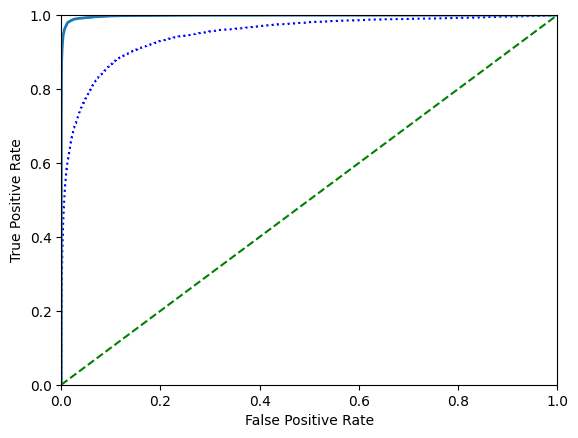

In [198]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.show()

In [200]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984375411864125

Multiclass Classification

In [202]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=int8)

In [203]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-15272.72059728, -19789.59734822,  -8401.86082223,
          5652.97836354, -11961.79563135,  -3388.96063485,
        -37535.41040809,  -8496.82965823,  -7037.51471279,
         -1198.33022882]])

In [204]:
np.argmax(some_digit_scores)

3

In [205]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [209]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([3], dtype=int8)

In [210]:
len(ovo_clf.estimators_)

45

In [211]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([3], dtype=int8)

In [212]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.96, 0.  , 0.02, 0.  , 0.  , 0.01, 0.  ]])

In [214]:
cross_val_score(sgd_clf, X_train, y_train, cv=2, scoring="accuracy")

array([0.87106667, 0.8545    ])

In [215]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64))

In [217]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/chrisdemta/Documents/Machine Learning from scratch/env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/chrisdemta/Documents/Machine Learning from scratch/env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9018, 0.9057, 0.9007])

Error Analysis

In [218]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
cm = confusion_matrix(y_train, y_train_pred)

/Users/chrisdemta/Documents/Machine Learning from scratch/env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/chrisdemta/Documents/Machine Learning from scratch/env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


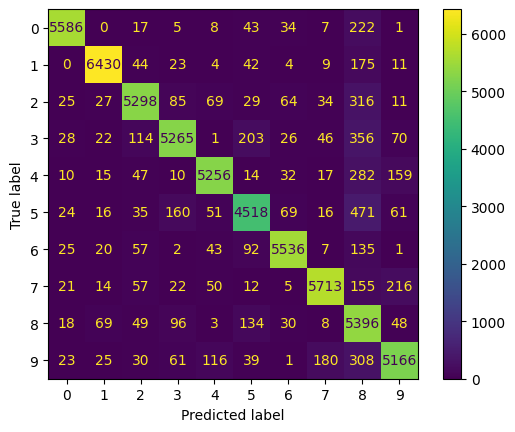

In [219]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=sgd_clf.classes_)
disp.plot()

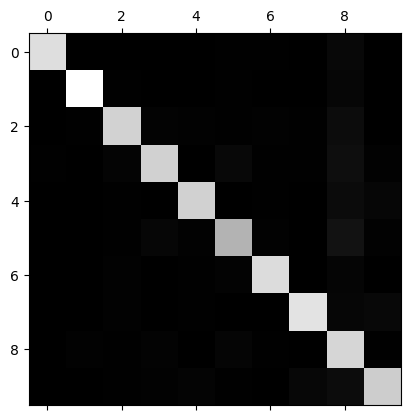

In [220]:
plt.matshow(cm, cmap=plt.cm.gray)
plt.show()

In [221]:
rows_sums = cm.sum(axis=1, keepdims=True)
norm_cm = cm/ rows_sums

In [222]:
norm_cm

array([[9.43103157e-01, 0.00000000e+00, 2.87016715e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 5.74033429e-03, 1.18183353e-03,
        3.74810062e-02, 1.68833361e-04],
       [0.00000000e+00, 9.53722931e-01, 6.52625334e-03, 3.41145061e-03,
        5.93295758e-04, 6.22960546e-03, 5.93295758e-04, 1.33491546e-03,
        2.59566894e-02, 1.63156333e-03],
       [4.19603894e-03, 4.53172205e-03, 8.89224572e-01, 1.42665324e-02,
        1.15810675e-02, 4.86740517e-03, 1.07418597e-02, 5.70661296e-03,
        5.30379322e-02, 1.84625713e-03],
       [4.56695482e-03, 3.58832164e-03, 1.85940303e-02, 8.58750612e-01,
        1.63105529e-04, 3.31104224e-02, 4.24074376e-03, 7.50285435e-03,
        5.80655684e-02, 1.14173870e-02],
       [1.71174255e-03, 2.56761383e-03, 8.04519000e-03, 1.71174255e-03,
        8.99691886e-01, 2.39643958e-03, 5.47757617e-03, 2.90996234e-03,
        4.82711400e-02, 2.72167066e-02],
       [4.42722745e-03, 2.95148497e-03, 6.45637336e-03, 2.95148497e-02,
   

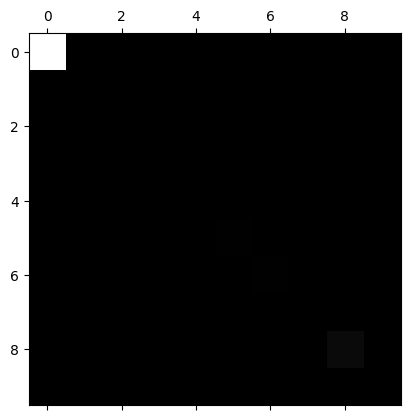

In [223]:
np.fill_diagonal(norm_cm, cm, 0)
plt.matshow(norm_cm, cmap=plt.cm.gray)
plt.show()

Something is wrong but okay

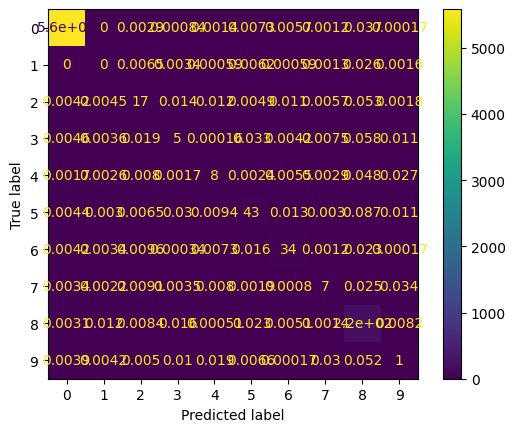

In [225]:
disp = ConfusionMatrixDisplay(confusion_matrix=norm_cm)
disp.plot()

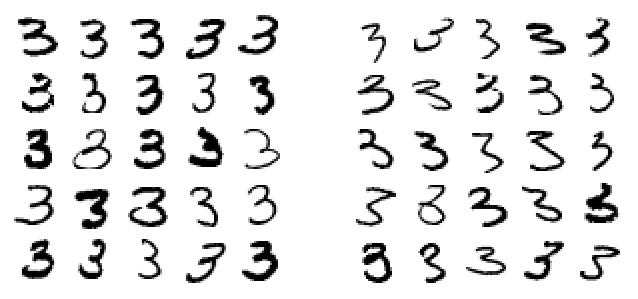

In [230]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)

In [229]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

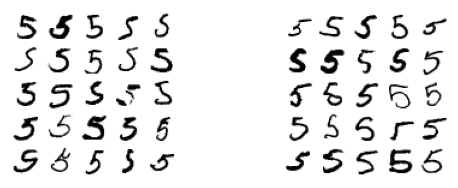

In [231]:
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

MultiLabel Classification, we use KNeighborsClassifier

In [232]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [234]:
knn_clf.predict([some_digit])

array([[False,  True]])

Evaluate Multilabel Classification

In [235]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

InvalidParameterError: The 'average' parameter of f1_score must be a str among {'weighted', 'binary', 'macro', 'samples', 'micro'} or None. Got 'marco' instead.

In [236]:
y_train_knn_pred

array([4, 3, 9, ..., 5, 0, 7], dtype=int8)

In [238]:
f1_score(y_train, y_train_knn_pred, average="macro")

0.968630502958165

MultiOutput Classification

In [239]:
import numpy as np

In [242]:
noise = np.random.randint(0, 100, (len(X_train), 784))

In [243]:
X_train_mod = X_train + noise

In [244]:
noise = np.random.randint(0, 100, (len(X_test), 784))

In [245]:
X_test_mod = X_test + noise

In [246]:
y_train_mod = X_train
y_test_mod = X_test

In [247]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'some_index' is not defined